In [129]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from ta import add_all_ta_features

In [130]:
WINDOW = 17  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '1y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'GOOG'  # Symbol of the desired stock
ROWS_TO_PREDICT = 128
# one day 16 rows of data

In [131]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-05-11 15:30:00-04:00,1410.969971,1411.530029,1403.000000,1403.280029,1403.280029,0
2020-05-11 16:00:00-04:00,1403.260000,1403.280000,1401.270000,1403.260000,1403.260000,0
2020-05-11 19:00:00-04:00,1404.950000,1404.950000,1404.830000,1404.830000,1404.830000,0
2020-05-12 04:00:00-04:00,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,0
2020-05-12 08:00:00-04:00,1409.000000,1409.000000,1408.250000,1408.250000,1408.250000,0
...,...,...,...,...,...,...
2021-05-11 12:30:00-04:00,2311.649902,2319.840088,2302.368896,2318.750000,2318.750000,100865
2021-05-11 13:30:00-04:00,2318.475098,2322.000000,2308.100098,2320.695068,2320.695068,99874
2021-05-11 14:30:00-04:00,2320.280029,2321.979980,2305.729980,2309.737793,2309.737793,131604


In [132]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low']

In [133]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [134]:
for name in important_columns:
    for i in range(1, 11):
        calculate_diffs(i, name)

data.head(10)

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-11 15:30:00-04:00,1410.969971,1411.530029,1403.000000,1403.280029,1403.280029,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 16:00:00-04:00,1403.260000,1403.280000,1401.270000,1403.260000,1403.260000,0,-7.709971,NaN,NaN,NaN,...,-1.730000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 19:00:00-04:00,1404.950000,1404.950000,1404.830000,1404.830000,1404.830000,0,1.690000,-6.019971,NaN,NaN,...,3.560000,1.830000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 04:00:00-04:00,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,0,0.050000,1.740000,-5.969971,NaN,...,0.170000,3.730000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 08:00:00-04:00,1409.000000,1409.000000,1408.250000,1408.250000,1408.250000,0,4.000000,4.050000,5.740000,-1.969971,...,3.250000,3.420000,6.980000,5.250000,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 09:00:00-04:00,1407.130000,1414.000000,1406.000000,1408.410000,1408.410000,0,-1.870000,2.130000,2.180000,3.870000,...,-2.250000,1.000000,1.170000,4.730000,3.000000,NaN,NaN,NaN,NaN,NaN
2020-05-12 09:30:00-04:00,1407.119995,1415.000000,1391.489990,1397.415405,1397.415405,394504,-0.010005,-1.880005,2.119995,2.169995,...,-14.510010,-16.760010,-13.510010,-13.340010,-9.780010,-11.510010,NaN,NaN,NaN,NaN
2020-05-12 10:30:00-04:00,1397.824951,1407.479980,1396.949951,1403.438354,1403.438354,176013,-9.295044,-9.305049,-11.175049,-7.175049,...,5.459961,-9.050049,-11.300049,-8.050049,-7.880049,-4.320049,-6.050049,NaN,NaN,NaN
2020-05-12 11:30:00-04:00,1404.069946,1405.025757,1399.165039,1403.209961,1403.209961,110898,6.244995,-3.050049,-3.060054,-4.930054,...,2.215088,7.675049,-6.834961,-9.084961,-5.834961,-5.664961,-2.104961,-3.834961,NaN,NaN


In [135]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

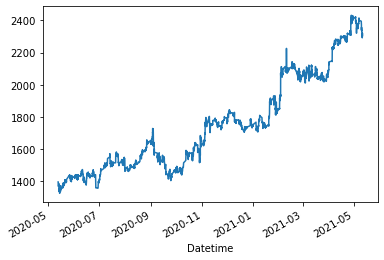

In [136]:
data['close'].plot()

In [137]:
data['close_pct'] = data['close'].pct_change()
data.head()

<ipython-input-137-b350896b28a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_pct'] = data['close'].pct_change()


,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,close_pct
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 13:30:00-04:00,1394.750000,1399.160034,1392.589966,1396.579956,1396.579956,101864,-8.810059,-9.319946,-3.074951,-12.369995,...,-6.575073,-4.359985,1.099976,-13.410034,-15.660034,-12.410034,-12.240034,-8.680034,-10.410034,NaN
2020-05-12 14:30:00-04:00,1396.579956,1397.800049,1388.449951,1389.969971,1389.969971,119507,1.829956,-6.980103,-7.489990,-1.244995,...,-6.020020,-10.715088,-8.500000,-3.040039,-17.550049,-19.800049,-16.550049,-16.380049,-12.820049,-0.004733
2020-05-12 15:30:00-04:00,1390.805786,1392.000000,1374.770020,1374.770020,1374.770020,223831,-5.774170,-3.944214,-12.754272,-13.264160,...,-17.819946,-19.699951,-24.395020,-22.179932,-16.719971,-31.229980,-33.479980,-30.229980,-30.059980,-0.010935
2020-05-12 16:00:00-04:00,1375.740000,1375.740000,1373.000000,1373.000000,1373.000000,0,-15.065786,-20.839956,-19.010000,-27.820059,...,-15.449951,-19.589966,-21.469971,-26.165039,-23.949951,-18.489990,-33.000000,-35.250000,-32.000000,-0.001288
2020-05-12 17:00:00-04:00,1369.500000,1369.500000,1369.500000,1369.500000,1369.500000,0,-6.240000,-21.305786,-27.079956,-25.250000,...,-5.270020,-18.949951,-23.089966,-24.969971,-29.665039,-27.449951,-21.989990,-36.500000,-38.750000,-0.002549


In [138]:
data.describe()

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,close_pct
count,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3.384000e+03,3384.000000,3384.000000,3384.000000,3384.000000,...,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3383.000000
mean,1787.195517,1792.579604,1781.427293,1787.437471,1787.437471,1.043014e+05,0.266516,0.534054,0.806647,1.075960,...,0.535406,0.803958,1.074824,1.339709,1.606150,1.865606,2.125925,2.386188,2.648304,0.000163
std,306.501369,307.656985,304.994636,306.575604,306.575604,1.370801e+05,9.031225,12.664239,15.324920,17.640258,...,23.466325,25.034366,26.447328,27.704340,28.906112,30.011107,30.887956,32.092499,33.374654,0.005447
min,1326.609985,1337.500000,1323.910034,1326.040039,1326.040039,0.000000e+00,-55.450000,-69.920044,-76.130054,-74.150684,...,-674.785850,-667.529990,-655.519980,-653.175010,-657.290000,-649.570029,-634.290000,-627.200000,-637.500000,-0.062984
25%,1507.730000,1512.378143,1503.647518,1509.453766,1509.453766,0.000000e+00,-3.540649,-5.215394,-6.755000,-8.005004,...,-5.346228,-6.870000,-8.366216,-9.160004,-9.523669,-10.252502,-10.962543,-12.000000,-12.720397,-0.001910
50%,1747.409973,1751.775022,1742.955017,1746.989990,1746.989990,7.866350e+04,0.140000,0.505005,0.805000,1.315029,...,0.935027,1.499585,1.789988,2.124954,2.595032,2.894973,2.812522,2.811432,3.000000,0.000034
75%,2064.132500,2070.082522,2055.947449,2064.000000,2064.000000,1.704140e+05,4.002500,6.272515,8.302484,10.094948,...,7.032528,8.990000,10.439955,12.057122,13.372548,14.345551,15.282502,16.359979,17.749971,0.002214
max,2432.470000,2452.377930,2427.495850,2432.020000,2432.020000,1.846607e+06,123.200000,142.490000,136.690000,137.109985,...,666.800000,661.300000,658.260000,659.320000,656.740000,649.650000,647.290000,647.320000,649.660117,0.078263


In [139]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [140]:
data

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,close_pct
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 13:30:00-04:00,1394.750000,1399.160034,1392.589966,1396.579956,1396.579956,101864,-8.810059,-9.319946,-3.074951,-12.369995,...,-6.575073,-4.359985,1.099976,-13.410034,-15.660034,-12.410034,-12.240034,-8.680034,-10.410034,NaN
2020-05-12 14:30:00-04:00,1396.579956,1397.800049,1388.449951,1389.969971,1389.969971,119507,1.829956,-6.980103,-7.489990,-1.244995,...,-6.020020,-10.715088,-8.500000,-3.040039,-17.550049,-19.800049,-16.550049,-16.380049,-12.820049,-0.004733
2020-05-12 15:30:00-04:00,1390.805786,1392.000000,1374.770020,1374.770020,1374.770020,223831,-5.774170,-3.944214,-12.754272,-13.264160,...,-17.819946,-19.699951,-24.395020,-22.179932,-16.719971,-31.229980,-33.479980,-30.229980,-30.059980,-0.010935
2020-05-12 16:00:00-04:00,1375.740000,1375.740000,1373.000000,1373.000000,1373.000000,0,-15.065786,-20.839956,-19.010000,-27.820059,...,-15.449951,-19.589966,-21.469971,-26.165039,-23.949951,-18.489990,-33.000000,-35.250000,-32.000000,-0.001288
2020-05-12 17:00:00-04:00,1369.500000,1369.500000,1369.500000,1369.500000,1369.500000,0,-6.240000,-21.305786,-27.079956,-25.250000,...,-5.270020,-18.949951,-23.089966,-24.969971,-29.665039,-27.449951,-21.989990,-36.500000,-38.750000,-0.002549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 12:30:00-04:00,2311.649902,2319.840088,2302.368896,2318.750000,2318.750000,100865,-4.765137,12.649902,19.789795,11.659902,...,19.368896,16.618896,20.368896,12.368896,7.368896,0.318896,-3.631104,2.108896,-26.141104,0.003523
2021-05-11 13:30:00-04:00,2318.475098,2322.000000,2308.100098,2320.695068,2320.695068,99874,6.825195,2.060059,19.475098,26.614990,...,-1.786133,25.100098,22.350098,26.100098,18.100098,13.100098,6.050098,2.100098,7.840098,0.000839
2021-05-11 14:30:00-04:00,2320.280029,2321.979980,2305.729980,2309.737793,2309.737793,131604,1.804932,8.630127,3.864990,21.280029,...,3.361084,-4.156250,22.729980,19.979980,23.729980,15.729980,10.729980,3.679980,-0.270020,-0.004722


In [141]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'open_1',
       'open_2', 'open_3', 'open_4', 'open_5', 'open_6', 'open_7', 'open_8',
       'open_9', 'open_10', 'high_1', 'high_2', 'high_3', 'high_4', 'high_5',
       'high_6', 'high_7', 'high_8', 'high_9', 'high_10', 'low_1', 'low_2',
       'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10',
       'close_pct'],
      dtype='object')

In [142]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [143]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\wrapper.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_adi"] = AccDistIndexIndicator(
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\wrapper.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_obv"] = OnBalanceVolumeIndicator(
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\wrapper.py:99: SettingWithCopyWarning: 
A value is trying to be se

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 13:30:00-04:00,1394.750000,1399.160034,1392.589966,1396.579956,1396.579956,101864,-8.810059,-9.319946,-3.074951,-12.369995,...,0.000000,1396.579956,0.000000,0.000000,0.000000,0.000000,-21.866920,0.000000,0.000000,1351.0000
2020-05-12 14:30:00-04:00,1396.579956,1397.800049,1388.449951,1389.969971,1389.969971,119507,1.829956,-6.980103,-7.489990,-1.244995,...,0.000000,1393.720436,0.000000,1.364163,0.272833,1.091330,-0.473298,-0.474422,-0.473298,1352.3439
2020-05-12 15:30:00-04:00,1390.805786,1392.000000,1374.770020,1374.770020,1374.770020,223831,-5.774170,-3.944214,-12.754272,-13.264160,...,0.000000,1385.410775,0.000000,9.647961,2.147858,7.500102,-1.093545,-1.099568,-1.561668,1350.0000
2020-05-12 16:00:00-04:00,1375.740000,1375.740000,1373.000000,1373.000000,1373.000000,0,-15.065786,-20.839956,-19.010000,-27.820059,...,0.000000,1379.790950,0.000000,0.201367,1.758560,-1.557193,-0.128750,-0.128833,-1.688407,1347.5200
2020-05-12 17:00:00-04:00,1369.500000,1369.500000,1369.500000,1369.500000,1369.500000,0,-6.240000,-21.305786,-27.079956,-25.250000,...,0.000000,1375.171529,0.000000,-8.431366,-0.279425,-8.151941,-0.254916,-0.255242,-1.939019,1335.9600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 12:30:00-04:00,2311.649902,2319.840088,2302.368896,2318.750000,2318.750000,100865,-4.765137,12.649902,19.789795,11.659902,...,-47.950736,2306.335849,-0.713365,30.067301,8.438716,21.628585,0.352283,0.351664,66.030594,NaN
2021-05-11 13:30:00-04:00,2318.475098,2322.000000,2308.100098,2320.695068,2320.695068,99874,6.825195,2.060059,19.475098,26.614990,...,-41.625580,2306.632664,-0.731668,25.661071,11.883187,13.777884,0.083884,0.083849,66.169868,NaN
2021-05-11 14:30:00-04:00,2320.280029,2321.979980,2305.729980,2309.737793,2309.737793,131604,1.804932,8.630127,3.864990,21.280029,...,-36.431788,2306.658155,-1.122122,23.956456,14.297841,9.658615,-0.472155,-0.473273,65.385289,NaN


In [144]:
higher_threshold = 1.5
lowest_threshold = -1.5
last_values_higher = []
last_values_lower = []
data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
while True:
    print(data['class_column'].value_counts())
    class_counts = data['class_column'].value_counts()
    if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
        break

    if len(last_values_higher) == 3:
        last_values_higher.pop(0)
    if len(last_values_lower) == 3:
        last_values_lower.pop(0)

    last_values_higher.append(higher_threshold)
    last_values_lower.append(lowest_threshold)
    if class_counts[0] > class_counts[1]:
        higher_threshold -= 0.01
    if class_counts[0] > class_counts[-1]:
        lowest_threshold += 0.01
    if class_counts[0] < class_counts[1]:
        higher_threshold += 0.01
    if class_counts[0] < class_counts[-1]:
        lowest_threshold -= 0.01

    if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
        break
    print(higher_threshold, lowest_threshold)
    data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)

data

<ipython-input-144-1209792257c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
<ipython-input-144-1209792257c8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)


 1    1818
-1    1382
 0     184
Name: class_column, dtype: int64
1.51 -1.51
 1    1818
-1    1382
 0     184
Name: class_column, dtype: int64
1.52 -1.52
 1    1818
-1    1382
 0     184
Name: class_column, dtype: int64
1.53 -1.53
 1    1818
-1    1380
 0     186
Name: class_column, dtype: int64
1.54 -1.54
 1    1818
-1    1380
 0     186
Name: class_column, dtype: int64
1.55 -1.55
 1    1817
-1    1380
 0     187
Name: class_column, dtype: int64
1.56 -1.56
 1    1817
-1    1380
 0     187
Name: class_column, dtype: int64
1.57 -1.57
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.58 -1.58
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.59 -1.59
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.6 -1.6
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.61 -1.61
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.62 -1.62
 1    1817
-1    1379
 0     188
Name: class_column, dtype: int64
1.6300000000

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 13:30:00-04:00,1394.750000,1399.160034,1392.589966,1396.579956,1396.579956,101864,-8.810059,-9.319946,-3.074951,-12.369995,...,1396.579956,0.000000,0.000000,0.000000,0.000000,-21.866920,0.000000,0.000000,1351.0000,-1
2020-05-12 14:30:00-04:00,1396.579956,1397.800049,1388.449951,1389.969971,1389.969971,119507,1.829956,-6.980103,-7.489990,-1.244995,...,1393.720436,0.000000,1.364163,0.272833,1.091330,-0.473298,-0.474422,-0.473298,1352.3439,-1
2020-05-12 15:30:00-04:00,1390.805786,1392.000000,1374.770020,1374.770020,1374.770020,223831,-5.774170,-3.944214,-12.754272,-13.264160,...,1385.410775,0.000000,9.647961,2.147858,7.500102,-1.093545,-1.099568,-1.561668,1350.0000,-1
2020-05-12 16:00:00-04:00,1375.740000,1375.740000,1373.000000,1373.000000,1373.000000,0,-15.065786,-20.839956,-19.010000,-27.820059,...,1379.790950,0.000000,0.201367,1.758560,-1.557193,-0.128750,-0.128833,-1.688407,1347.5200,-1
2020-05-12 17:00:00-04:00,1369.500000,1369.500000,1369.500000,1369.500000,1369.500000,0,-6.240000,-21.305786,-27.079956,-25.250000,...,1375.171529,0.000000,-8.431366,-0.279425,-8.151941,-0.254916,-0.255242,-1.939019,1335.9600,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 12:30:00-04:00,2311.649902,2319.840088,2302.368896,2318.750000,2318.750000,100865,-4.765137,12.649902,19.789795,11.659902,...,2306.335849,-0.713365,30.067301,8.438716,21.628585,0.352283,0.351664,66.030594,NaN,0
2021-05-11 13:30:00-04:00,2318.475098,2322.000000,2308.100098,2320.695068,2320.695068,99874,6.825195,2.060059,19.475098,26.614990,...,2306.632664,-0.731668,25.661071,11.883187,13.777884,0.083884,0.083849,66.169868,NaN,0
2021-05-11 14:30:00-04:00,2320.280029,2321.979980,2305.729980,2309.737793,2309.737793,131604,1.804932,8.630127,3.864990,21.280029,...,2306.658155,-1.122122,23.956456,14.297841,9.658615,-0.472155,-0.473273,65.385289,NaN,0


In [145]:
# Class divide
data['class_column'].value_counts()

 1    1138
 0    1125
-1    1121
Name: class_column, dtype: int64

In [146]:
filename_to_export = f'../data/preprocess_new/{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

../data/preprocess_new/GOOG_1y_17_diff_11_05_2021 21_44_49_full.csv
